## Source
1. https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html

In [29]:
import time
import numpy as np
from scipy.stats import beta
import matplotlib  # noqa
import matplotlib.pyplot as plt
matplotlib.use('Agg')  # noqa

In [30]:
class Bandit(object):

    def generate_reward(self, i):
        raise NotImplementedError

In [31]:
class BernoulliBandit(Bandit):

    def __init__(self, n, probas=None):
        assert probas is None or len(probas) == n
        self.n = n
        if probas is None:
            np.random.seed(int(time.time()))
            self.probas = [np.random.random() for _ in range(self.n)]
        else:
            self.probas = probas

        self.best_proba = max(self.probas)

    def generate_reward(self, i):
        if np.random.random() < self.probas[i]:
            return 1
        else:
            return 0

In [32]:
pure_bandit = BernoulliBandit(10000)

In [33]:
pure_bandit.generate_reward(1)

1

In [14]:
pure_bandit.probas

[0.6528379406450309,
 0.7365804581745233,
 0.2622319938218105,
 0.9439219932463291,
 0.6692651835236137,
 0.6775953180637452,
 0.1175581671953464,
 0.1826241959795074,
 0.7053042444499712,
 0.9789410309004246,
 0.36218980691721503,
 0.03238698423552877,
 0.41835317487072265,
 0.4005408404040467,
 0.385385080981857,
 0.8792779961516387,
 0.37471254755257555,
 0.07958045166524974,
 0.8834171345218073,
 0.6220210111679991,
 0.9562131275676482,
 0.5648250574975809,
 0.6583724947198439,
 0.7408228943897295,
 0.46214850990776846,
 0.9404228526203969,
 0.8759931003366291,
 0.857842572173901,
 0.8722149818699771,
 0.5510830503216826,
 0.9537416094095091,
 0.16481498089596802,
 0.3672057029132465,
 0.549381713257147,
 0.5471418655204381,
 0.5006864680609194,
 0.9217773395153449,
 0.7115039959185154,
 0.170258007585679,
 0.6546998186989129,
 0.7266740767883519,
 0.4743897552519031,
 0.8142813879252105,
 0.5650606661662059,
 0.23528704731710748,
 0.8914299980437256,
 0.33924170187234215,
 0.51844

In [18]:
class Solver(object):
    def __init__(self, bandit):
        """
        bandit (Bandit): the target bandit to solve.
        """
        assert isinstance(bandit, BernoulliBandit)
        np.random.seed(int(time.time()))

        self.bandit = bandit

        self.counts = [0] * self.bandit.n
        self.actions = []  # A list of machine ids, 0 to bandit.n-1.
        self.regret = 0.  # Cumulative regret.
        self.regrets = [0.]  # History of cumulative regret.

    def update_regret(self, i):
        # i (int): index of the selected machine.
        self.regret += self.bandit.best_proba - self.bandit.probas[i]
        self.regrets.append(self.regret)

    @property
    def estimated_probas(self):
        raise NotImplementedError

    def run_one_step(self):
        """Return the machine index to take action on."""
        raise NotImplementedError

    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()

            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)

In [19]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, eps, init_proba=1.0):
        """
        eps (float): the probability to explore at each time step.
        init_proba (float): default to be 1.0; optimistic initialization
        """
        super(EpsilonGreedy, self).__init__(bandit)

        assert 0. <= eps <= 1.0
        self.eps = eps

        self.estimates = [init_proba] * self.bandit.n  # Optimistic initialization

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        if np.random.random() < self.eps:
            # Let's do random exploration!
            i = np.random.randint(0, self.bandit.n)
        else:
            # Pick the best one.
            i = max(range(self.bandit.n), key=lambda x: self.estimates[x])

        r = self.bandit.generate_reward(i)
        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

In [24]:
class UCB1(Solver):
    def __init__(self, bandit, init_proba=1.0):
        super(UCB1, self).__init__(bandit)
        self.t = 0
        self.estimates = [init_proba] * self.bandit.n

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        self.t += 1

        # Pick the best one with consideration of upper confidence bounds.
        i = max(range(self.bandit.n), key=lambda x: self.estimates[x] + np.sqrt(
            2 * np.log(self.t) / (1 + self.counts[x])))
        r = self.bandit.generate_reward(i)

        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

In [36]:
class BayesianUCB(Solver):
    """Assuming Beta prior."""

    def __init__(self, bandit, c=3, init_a=1, init_b=1):
        """
        c (float): how many standard dev to consider as upper confidence bound.
        init_a (int): initial value of a in Beta(a, b).
        init_b (int): initial value of b in Beta(a, b).
        """
        super(BayesianUCB, self).__init__(bandit)
        self.c = c
        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / float(self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        # Pick the best one with consideration of upper confidence bounds.
        i = max(
            range(self.bandit.n),
            key=lambda x: self._as[x] / float(self._as[x] + self._bs[x]) + beta.std(
                self._as[x], self._bs[x]) * self.c
        )
        r = self.bandit.generate_reward(i)

        # Update Gaussian posterior
        self._as[i] += r
        self._bs[i] += (1 - r)

        return i


class ThompsonSampling(Solver):
    def __init__(self, bandit, init_a=1, init_b=1):
        """
        init_a (int): initial value of a in Beta(a, b).
        init_b (int): initial value of b in Beta(a, b).
        """
        super(ThompsonSampling, self).__init__(bandit)

        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / (self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        samples = [np.random.beta(self._as[x], self._bs[x]) for x in range(self.bandit.n)]
        i = max(range(self.bandit.n), key=lambda x: samples[x])
        r = self.bandit.generate_reward(i)

        self._as[i] += r
        self._bs[i] += (1 - r)

        return i

## Inits
Args:  
- K (int): number of slot machines.  
- N (int): number of time steps to try.

In [40]:
test_solvers

In [42]:
def plot_results(solvers, solver_names, figname):
    """
    Plot the results by multi-armed bandit solvers.
    Args:
        solvers (list<Solver>): All of them should have been fitted.
        solver_names (list<str)
        figname (str)
    """
    assert len(solvers) == len(solver_names)
    assert all(map(lambda s: isinstance(s, Solver), solvers))
    assert all(map(lambda s: len(s.regrets) > 0, solvers))

    b = solvers[0].bandit

    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.3, wspace=0.3)

    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    # Sub.fig. 1: Regrets in time.
    for i, s in enumerate(solvers):
        ax1.plot(range(len(s.regrets)), s.regrets, label=solver_names[i])

    ax1.set_xlabel('Time step')
    ax1.set_ylabel('Cumulative regret')
    ax1.legend(loc=9, bbox_to_anchor=(1.82, -0.25), ncol=5)
    ax1.grid('k', ls='--', alpha=0.3)

    # Sub.fig. 2: Probabilities estimated by solvers.
    sorted_indices = sorted(range(b.n), key=lambda x: b.probas[x])
    ax2.plot(range(b.n), [b.probas[x] for x in sorted_indices], 'k--', markersize=12)
    for s in solvers:
        ax2.plot(range(b.n), [s.estimated_probas[x] for x in sorted_indices], 'x', markeredgewidth=2)
    ax2.set_xlabel('Actions sorted by ' + r'$\theta$')
    ax2.set_ylabel('Estimated')
    ax2.grid('k', ls='--', alpha=0.3)

    # Sub.fig. 3: Action counts
    for s in solvers:
        ax3.plot(range(b.n), np.array(s.counts) / float(len(solvers[0].regrets)), ls='steps', lw=2)
    ax3.set_xlabel('Actions')
    ax3.set_ylabel('Frac. # trials')
    ax3.grid('k', ls='--', alpha=0.3)

    plt.savefig(figname)

In [43]:
for s in test_solvers:
    s.run(N)

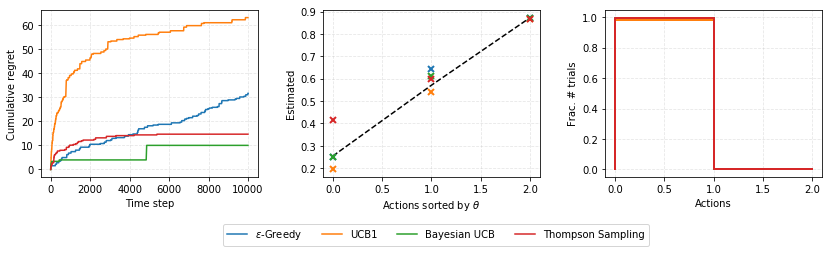

In [44]:
plot_results(test_solvers, names, "results_K{}_N{}.png".format(K, N))

In [46]:
def experiment(K,N):
    b = BernoulliBandit(K)
    test_solvers = [
        EpsilonGreedy(b, 0.01),
        UCB1(b),
        BayesianUCB(b, 3, 1, 1),
        ThompsonSampling(b, 1, 1)]
    names = [
        r'$\epsilon$' + '-Greedy',
        'UCB1',
        'Bayesian UCB',
        'Thompson Sampling'
    ]
    for s in test_solvers:
        s.run(N)

    plot_results(test_solvers, names, "results_K{}_N{}.png".format(K, N))

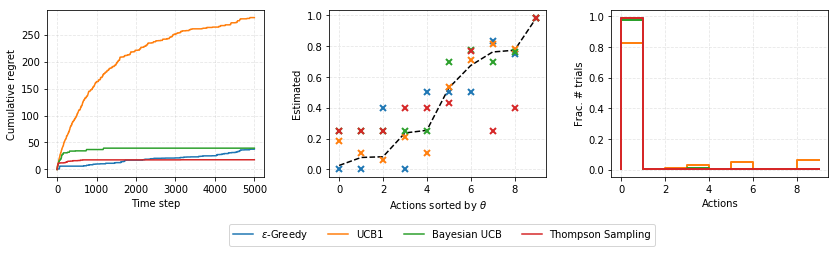

In [47]:
experiment(10, 5000)